# Super-resolution with GenFocal

## Dependency and dataset preparation

First install dependencies with `pip`.

In [ ]:
!pip install git+https://github.com/google-research/swirl-dynamics.git@main
!pip install cartopy dask zarr

And make necessary imports, including GenFocal super-resolution modules and visualization tools

In [28]:
import json
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.projects.genfocal.super_resolution import data
from swirl_dynamics.projects.genfocal.super_resolution import sampling
from swirl_dynamics.projects.genfocal.super_resolution import training

Next download example input data hosted on our Google Cloud storage bucket, consisting of the following:

*   Model checkpoint.
*   Low-resolution input (1.5-degree spatial resolution, daily mean) - for demonstration purpose, we use the ground truth ERA5 low-resolution data as input; when running on debiasing outputs, the corresponding dataset should be processed to have the same format.
*   Input normalizing statistics (mean & standard deviation) of the low-resolution input, pre-computed for a reference historical period.
*   Output denormalizing climatology (mean & standard deviation for fixed day-of-the-year and hour-of-the-day), pre-computed for a reference historical period.

Use `gsutil` ([installation instructions](https://cloud.google.com/storage/docs/gsutil_install)) to download the data.



In [5]:
save_path = "super-resolution/"

In [4]:
!mkdir {save_path}

In [ ]:
# Model checkpoint: for the conterminous US (CONUS) region
!gsutil -m -q cp -R gs://genfocal/super_resolution/checkpoints/conus_7d_20150801_t2m_w10m_q1000_msl {save_path}

In [ ]:
# Example input data: ground truth low-resolution ERA5 for 2015
!gsutil -m -q cp -R gs://genfocal/super_resolution/inference/example_inputs/era5_1p5deg_2015_global_t2m_w10m_q1000_msl_z200_z500.zarr {save_path}

In [ ]:
# Input normalizing statistics
!gsutil -m -q cp -R gs://genfocal/super_resolution/inference/example_inputs/era5_1p5deg_stats_global_t2m_w10m_q1000_msl_z200_z500.zarr {save_path}

In [ ]:
# Output denormalizing statistics
!gsutil -m -q cp -R gs://genfocal/super_resolution/inference/example_inputs/era5_0p25deg_residual_clim_conus_t2m_w10m_q1000_msl.zarr {save_path}

## Run inference

First we load the config for the trained diffusion neural network, instantiate the module, and build an inference denoising function. There is a copy of the config inside the checkpoint folder.

In [43]:
current_dir = os.getcwd()
checkpoint_path = os.path.join(current_dir, save_path, "checkpoint")

with open(os.path.join(checkpoint_path, "config.json"), "r") as f:
  model_args = json.load(f)

backbone = dfn_lib.PreconditionedDenoiserUNet3d(**model_args)
denoise_fn = training.DenoisingTrainer.inference_fn_from_state_dict(
    state=training.DenoisingModelTrainState.restore_from_orbax_ckpt(
        ckpt_dir=checkpoint_path, step=300_000,
    ),
    denoiser=backbone,
    use_ema=True,
)

The CONUS region, where the loaded model is trained, is defined by

In [10]:
LON_RANGE = (234, 294)
LAT_RANGE = (22.5, 52.5)

Next we define the input dataloader, providing the paths to the example inputs downloaded.

In [ ]:
INPUT_DATASET_PATH = f"{save_path}/era5_1p5deg_2015_global_t2m_w10m_q1000_msl_z200_z500.zarr"
INPUT_STATS_PATH = f"{save_path}/era5_1p5deg_stats_global_t2m_w10m_q1000_msl_z200_z500.zarr"
OUTPUT_CLIM_PATH = f"{save_path}/era5_0p25deg_residual_clim_conus_t2m_w10m_q1000_msl.zarr"

and the variables inside the datasets. All variables must be present in input, input stats and output climatology datasets.

In [11]:
variables = ["T2m", "W10m", "Q1000", "MSL"]

In [14]:
cond_loader = data.InputLoader(
    date_range=("2015-01-01", "2015-12-31"),
    daily_dataset_path=INPUT_DATASET_PATH,
    daily_variables=[data.DatasetVariable(v, None, v) for v in variables],
    daily_stats_path=INPUT_STATS_PATH,
    dims_order=("time", "longitude", "latitude"),
)

Next we specify the diffusion scheme:

In [15]:
scheme = dfn_lib.create_variance_exploding_scheme(
    sigma=dfn_lib.tangent_noise_schedule(
        clip_max=80.0, start=-1.5, end=1.5
    ),
    data_std=1.0,
)

The sampler applies the same denoising function in parallel to generate different date chunks. The chunks have overlaps with neighboring ones and the overlapping regions are reconciled after each denoising step to ensure consistency. See section I.4.3 in our [paper](https://arxiv.org/abs/2412.08079) for more detailed explanation.

In particular, we emphasize the `total_sample_days` parameter, which is not a free parameter but depends on other parameters (we made it explicit to make users aware of the relationship):

*   `num_days`: The number of days covered by the denoising function (i.e. the "length" of the date chunks); this parameter is a static property (fixed after training) of the trained denoising neural network.
*   `num_overlap_days`: The number of overlapped days between neighboring date chunks.
*   The number of accelerator devices available (check via `jax.device_count()`).

The relationship is

```
total_sample_days = (num_devices - 1) * (num_model_days - num_overlap_days) + num_model_days
```



In [18]:
NUM_MODEL_DAYS = 7
NUM_OVERLAP_DAYS = 1
NUM_DEVICES = jax.device_count()

In [20]:
total_sample_days = (NUM_DEVICES - 1) * (NUM_MODEL_DAYS - NUM_OVERLAP_DAYS) + NUM_MODEL_DAYS
print(
    f"With {NUM_MODEL_DAYS=}, {NUM_OVERLAP_DAYS=}, {NUM_DEVICES=}, "
    f"the total number of days sampled is {total_sample_days}."
)

With NUM_MODEL_DAYS=7, NUM_OVERLAP_DAYS=1, NUM_DEVICES=1, the total number of days sampled is 7.


Now we are ready to define the sampler object and run inference:

In [21]:
OUTPUT_PATH = "sample_outputs/sr_CONUS_2015.zarr"

In [24]:
sampler = sampling.TrajectorySamplerParallel(
    start_date="2015-08-01",
    total_sample_days=total_sample_days,
    variables=variables,
    lon_coords=np.arange(*LON_RANGE, 0.25),
    lat_coords=np.arange(*LAT_RANGE, 0.25),
    scheme=scheme,
    denoise_fn=denoise_fn,
    tspan=dfn_lib.edm_noise_decay(
        scheme=scheme, num_steps=256,
    ),
    cond_loader=cond_loader,
    lowres_ds=xr.open_zarr(INPUT_DATASET_PATH),
    stats_ds=xr.open_zarr(OUTPUT_CLIM_PATH),
    store_path=OUTPUT_PATH,
    hour_interval=2,
    batch_size=1,
    num_model_days=NUM_MODEL_DAYS,
    num_overlap_days=NUM_OVERLAP_DAYS,
    interp_method="linear",
    sampling_type="sde",
)

sampler.generate_and_save(seed=999, num_samples=1)

## Inspect output

We load up the samples to make sure that inference has gone as expected.

In [25]:
samples = xr.open_zarr(OUTPUT_PATH)

First, we inspect the dataset metadata:

In [26]:
samples

<xarray.Dataset> Size: 77MB
Dimensions:    (member: 1, time: 84, longitude: 240, latitude: 120)
Coordinates:
  * latitude   (latitude) float64 960B 22.5 22.75 23.0 ... 51.75 52.0 52.25
  * longitude  (longitude) float64 2kB 234.0 234.2 234.5 ... 293.2 293.5 293.8
  * member     (member) int64 8B 0
  * time       (time) datetime64[ns] 672B 2015-08-01 ... 2015-08-07T22:00:00
Data variables:
    MSL        (member, time, longitude, latitude) float64 19MB dask.array<chunksize=(1, 84, 240, 120), meta=np.ndarray>
    Q1000      (member, time, longitude, latitude) float64 19MB dask.array<chunksize=(1, 84, 240, 120), meta=np.ndarray>
    T2m        (member, time, longitude, latitude) float64 19MB dask.array<chunksize=(1, 84, 240, 120), meta=np.ndarray>
    W10m       (member, time, longitude, latitude) float64 19MB dask.array<chunksize=(1, 84, 240, 120), meta=np.ndarray>

Some utility functions for plotting.

In [29]:
def make_imshow_plot(ax, data, **kwargs):
  """Plots the data and add the coastlines."""
  # Shifts the longitudinal range to be centered in 180°.
  lon_range_0, lon_range_1 = LON_RANGE[0] - 180,  LON_RANGE[1] - 180
  im = ax.imshow(
      data,
      extent=[lon_range_0, lon_range_1, LAT_RANGE[0], LAT_RANGE[1]],
      transform=ccrs.PlateCarree(central_longitude=180), **kwargs
  )
  ax.set_aspect("equal")
  ax.set_xlim([lon_range_0, lon_range_1])
  ax.set_ylim(LAT_RANGE)
  ax.coastlines(resolution="50m", linewidth=0.3, color="black")
  ax.add_feature(cfeature.OCEAN, color="white")
  ax.add_feature(cfeature.LAND, color="white")
  return im


def create_fig_and_grid():
  """Creates the figure object and the corresponding grid."""
  fig = plt.figure(figsize=(15, 22), dpi=100)
  gs = mpl.gridspec.GridSpec(
      8, 4,  wspace=0.01, hspace=0.21,
      width_ratios=[1, 1, 1, 0.05],
      height_ratios=8 * [1,],
  )

  return fig, gs

Generating plots to visualize the generated fields.

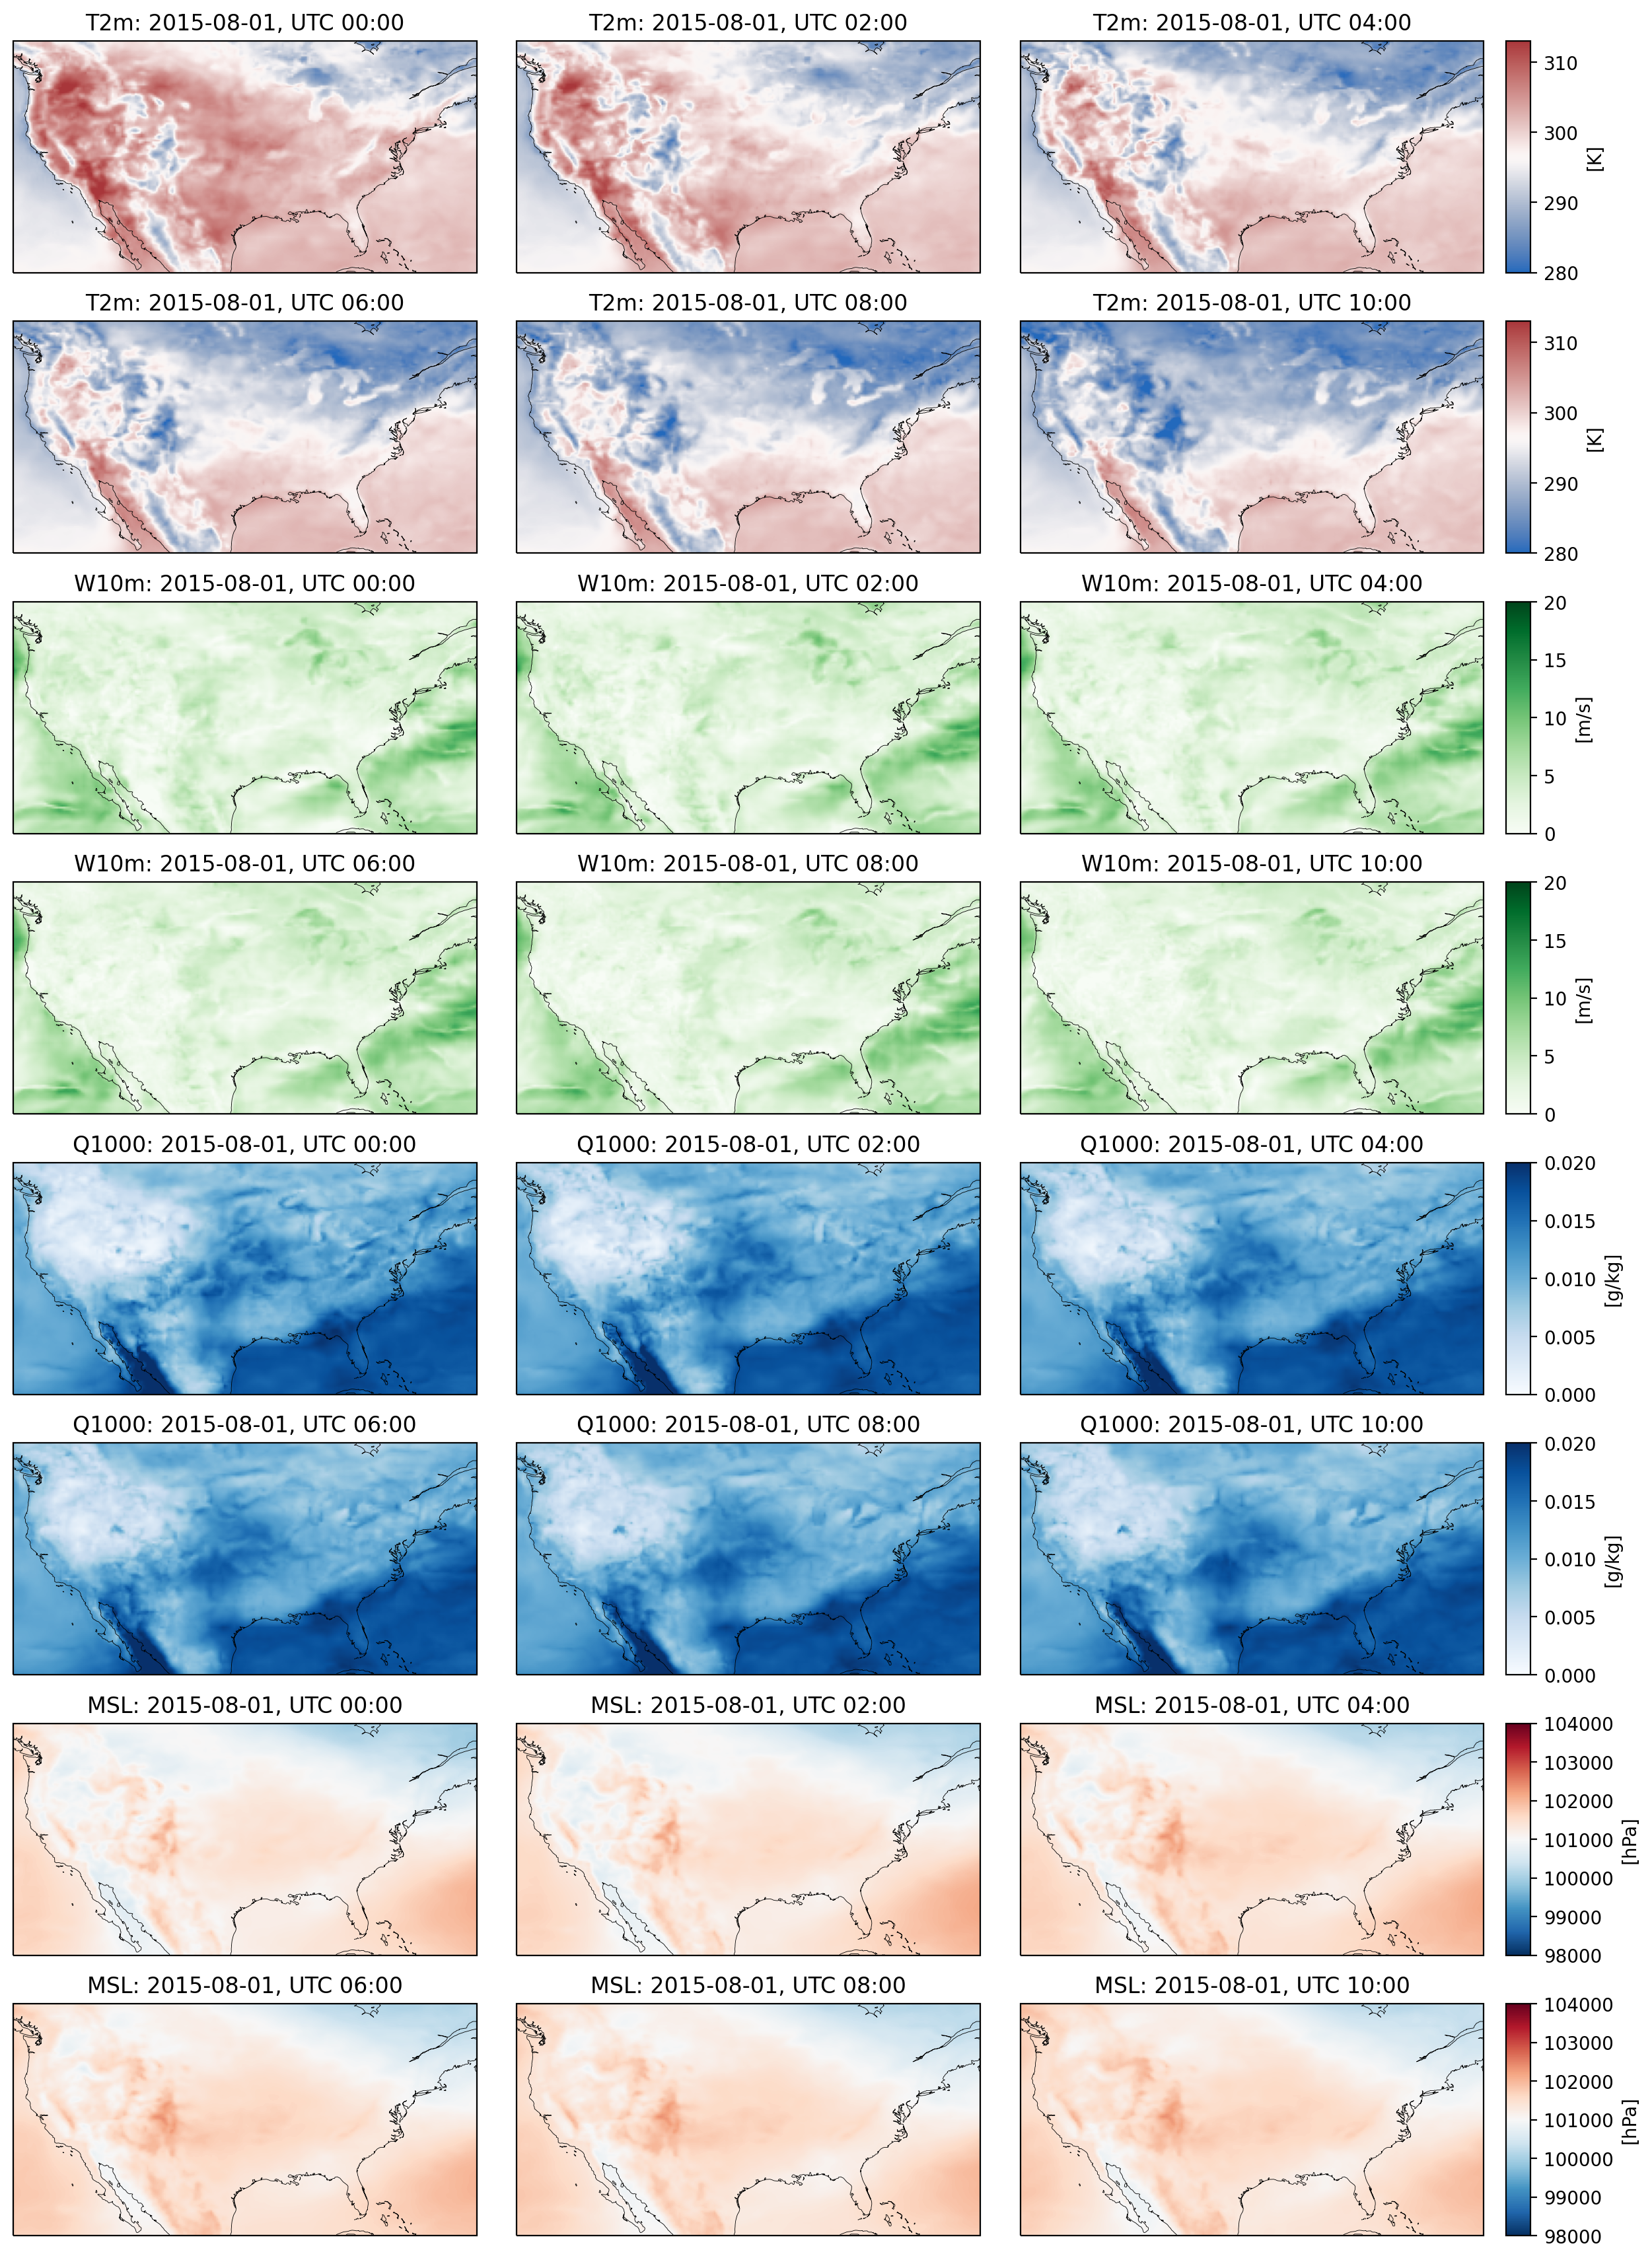

In [44]:
idx_start_time = 0
idx_member = 0

fig, gs = create_fig_and_grid()
heat_cmap = sns.color_palette("vlag", as_cmap=True, n_colors=21)

idx_field_dict = {
    "T2m": ("[K]", heat_cmap, (280.0, 313.0)),
    "W10m": ("[m/s]", "Greens", (0.0, 20.0)),
    "Q1000": ("[g/kg]", "Blues", (0.0, 0.02)),
    "MSL": ("[hPa]", "RdBu_r", (98000.0, 104000.0)),
}

for i, (field, (unit, cmap, (vmin, vmax))) in enumerate(
    idx_field_dict.items()
):

  for j in range(6):
    ax = fig.add_subplot(
        gs[i * 2 + j // 3, j % 3], projection=ccrs.PlateCarree(central_longitude=180)
    )
    idx_time = idx_start_time + j
    im = make_imshow_plot(
        ax, np.rot90(samples[field][idx_member, idx_time, :, :].to_numpy()),
        cmap=cmap, vmin=vmin, vmax=vmax,
    )
    time = samples["time"].to_numpy()[idx_time]
    day = time.astype("datetime64[D]")
    hour = str(time.astype("datetime64[h]")).split("T")[1]
    ax.set_title(f"{field}: {day}, UTC {hour}:00")

    if j % 3 == 2:
      cax = fig.add_subplot(gs[i * 2 + j // 3, 3])
      cbar = fig.colorbar(im, cax=cax)
      cbar.set_label(unit, fontsize=10)